In [3]:
# import the libraries as shown below

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
valid_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

In [5]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 2s 0us/step


In [6]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [7]:
# useful for getting number of output classes
folders = glob('/kaggle/input/chest-xray-pneumonia/chest_xray/train/*')

In [8]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

In [9]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [10]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [12]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/kaggle/input/chest-xray-pneumonia/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [14]:
test_set = test_datagen.flow_from_directory('/kaggle/input/chest-xray-pneumonia/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [15]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/tmp/ipykernel_32/3314549357.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/5
163/163 [==============================] - 144s 832ms/step - loss: 0.2111 - accuracy: 0.9185 - val_loss: 0.2155 - val_accuracy: 0.9231
Epoch 2/5
163/163 [==============================] - 100s 614ms/step - loss: 0.1190 - accuracy: 0.9542 - val_loss: 0.4652 - val_accuracy: 0.8686
Epoch 3/5
163/163 [==============================] - 100s 611ms/step - loss: 0.0911 - accuracy: 0.9649 - val_loss: 0.3017 - val_accuracy: 0.9151
Epoch 4/5
163/163 [==============================] - 102s 624ms/step - loss: 0.0950 - accuracy: 0.9636 - val_loss: 0.3345 - val_accuracy: 0.9215
Epoch 5/5
163/163 [==============================] - 99s 606ms/step - loss: 0.0926 - accuracy: 0.9657 - val_loss: 0.9646 - val_accuracy: 0.7837


In [16]:
# Save the model
model.save('pneumonia_model.h5')

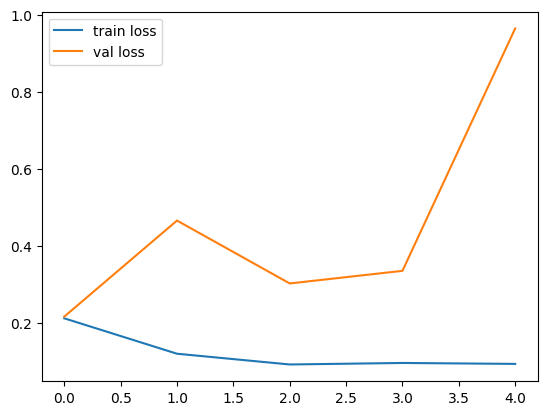

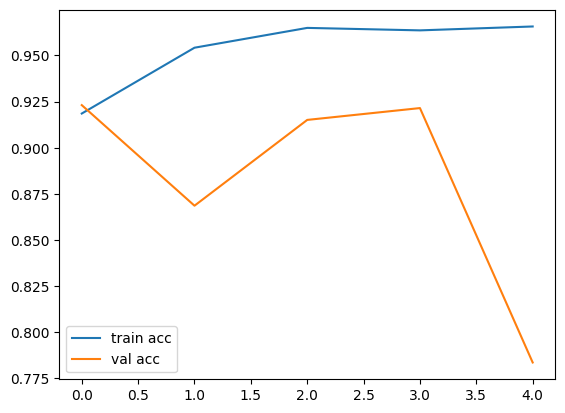

<Figure size 640x480 with 0 Axes>

In [17]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [1]:
from keras.models import load_model
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

# Load the trained model
model = load_model('/kaggle/working/pneumonia_model.h5')

# Load an example image for prediction
image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg'
img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img_data = preprocess_input(img)
predictions = model.predict(img_data)
results=predictions[0][0]
print(predictions)
# Interpret the prediction
if results==1:
    print("The image is NORMAL.")
else:
    print("The image indicates PNEUMONIA.")

OSError: No file or directory found at /kaggle/working/pneumonia_model.h5

In [22]:
from keras.models import load_model
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

# Load the trained model
model = load_model('/kaggle/working/pneumonia_model.h5')

# Load an example image for prediction
image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg'
img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img_data = preprocess_input(img)
predictions = model.predict(img_data)
results=predictions[0][0]
print(predictions)
# Interpret the prediction
if results==1:
    print("The image is NORMAL.")
else:
    print("The image indicates PNEUMONIA.")

1/1 [==============================] - 0s 139ms/step
[[0. 1.]]
The image indicates PNEUMONIA.
